In [1]:
%load_ext autoreload
%autoreload 2

import sys, os
import pandas as pd
import numpy as np
from tqdm import tqdm
import wandb
import matplotlib.pyplot as plt
import torch

sys.path.append(os.path.join(os.getcwd(), '../symlie'))
from misc.utils import NumpyUtils, Results, tensor_operation, numpy_operation, Args
from misc.viz import plot2d
from model.networks.linear import LinearP
from model.setup import find_id_for_P, load_P_pred
from model.networks.linear import CalculatedP
from data.dataset import FlatDataset
from misc.viz import plot1d, plot2d
from data.generate_2d import sine1d, sine2d, flower, mnist
from data.generate_2d import Create2dData
from data.generate_data import datasets

In [2]:
def plot_data(dataset, N_plot=5):
    for data_kwargs in ['data_kwargs_show', 'data_kwargs']:
        create_data = Create2dData(dataset['create_sample_func'], dataset[data_kwargs], dataset['transform_kwargs'])
        out = create_data(N = N_plot)
        x, y = out['x'].reshape(N_plot, *dataset[data_kwargs]['grid_size']), out['y']
        dataset['plot_func'](x, y)

def assert_unique(df_map_new):
    df_map_new = df_map_new.copy()
    del df_map_new['run_id']
    for col in df_map_new.columns:
        df_map_new[col] = df_map_new[col].astype(str)
    assert len(df_map_new) == len(df_map_new.drop_duplicates())


In [3]:
df = pd.read_pickle('../logs/store/results_df.pkl')
print(df.shape)
print(df.columns)
df.head()

(147, 41)
Index(['lr', 'net', 'bias', 'name', 'seed', 'tags', 'test', 'n_val', 'train',
       'y_low', 'device', 'logger', 'n_test', 'run_id', 'y_high', 'log_dir',
       'n_train', 'predict', 'version', 'data_dir', 'eps_mult', 'n_splits',
       'criterion', 'do_return', 'earlystop', 'grid_size', 'noise_std',
       'only_flip', 'batch_size', 'max_epochs', 'data_kwargs', 'num_workers',
       'generate_data', 'model_summary', 'args_processed', 'do_return_model',
       'transform_kwargs', 'persistent_workers', 'run_name', 'test_loss',
       'space_length'],
      dtype='object')


,lr,net,bias,name,seed,tags,test,n_val,train,y_low,...,num_workers,generate_data,model_summary,args_processed,do_return_model,transform_kwargs,persistent_workers,run_name,test_loss,space_length
0,0.010,TrainP,False,None,3,"[mnist, long2]",True,1000,True,NaN,...,18,False,False,True,False,"{'eps_mult': [0, 0, 1, 1], 'only_flip': False}",True,divine-spaceship-418,0.000711,NaN
1,0.010,TrainP,False,None,1,"[mnist, long2]",True,1000,True,NaN,...,18,False,False,True,False,"{'eps_mult': [0, 0, 1, 1], 'only_flip': False}",True,cosmic-universe-419,0.000709,NaN
2,0.010,TrainP,False,None,2,"[mnist, long2]",True,1000,True,NaN,...,18,False,False,True,False,"{'eps_mult': [0, 0, 1, 1], 'only_flip': False}",True,ancient-resonance-417,0.000752,NaN
3,0.001,Predict-TrainedP,False,None,3,"[mnist-predict, long]",True,1000,True,NaN,...,18,False,False,True,False,"{'eps_mult': [0, 0, 1, 1], 'only_flip': False}",True,scarlet-sky-409,2.168962,NaN
4,0.001,Predict-TrainedP,False,None,1,"[mnist-predict, long]",True,1000,True,NaN,...,18,False,False,True,False,"{'eps_mult': [0, 0, 1, 1], 'only_flip': False}",True,likely-brook-407,1.779646,NaN


## Sine1d

In [ ]:
d = df[df['tags'].astype(str).str.contains('sine1d')]
d.shape

In [ ]:
n_trains = d['n_train'].unique()
lrs = d['lr'].unique()
seeds = d['seed'].unique()
n_trains, lrs, seeds

In [ ]:
d_agg = d.groupby(['n_train', 'lr'])['test_loss']
means = d_agg.mean()
stds = d_agg.std()

fig, ax = plt.subplots()
means.plot(kind='barh', xerr=stds, ax = ax)
ax.set_xlabel('Test Loss')
ax.set_xscale('log')
plt.show()

In [ ]:
df_map_old = pd.read_pickle('../logs/store/map_df.pkl')
df_map_old

In [ ]:
df_map_new = d[(d['n_train'] == 10_000) & (d['lr'] == 1e-3)][df_map_old.columns]
df_map_new

In [ ]:
df_map = pd.concat([df_map_old, df_map_new]).drop_duplicates(subset=['run_id']).reset_index(drop=True)
df_map
# df_map.to_pickle('../logs/store/map_df.pkl')

In [ ]:
Ps = []
for seed in seeds:

    args = Args(**dict(
        n_train = 10_000,
        lr = 0.001,
        tags = ['sine1d'],
        seed = seed,
        data_kwargs = {'y_low': 1, 'y_high': 3, 'grid_size': [1, 7], 'noise_std': 0.5},
        transform_kwargs = {'eps_mult': [0, 0, 1, 0], 'only_flip': False},
        data_dir = '../data/sine1d',
    ))

    run_id = find_id_for_P(args)
    P = load_P_pred(run_id)
    Ps.append(P)
Ps = torch.stack(Ps)

plot2d(Ps, l = 10)

## Sine1d-predict

In [ ]:
plot_data(datasets['sine2d'], N_plot=5)

In [ ]:
d = df[df['tags'].astype(str).str.contains('sine1d-predict')].reset_index(drop=True)

data_kwargs_all = d['data_kwargs'].values
for data_kwargs in data_kwargs_all:
    assert data_kwargs == data_kwargs_all[0]
data_kwargs = data_kwargs_all[0]

transform_kwargs_all = d['transform_kwargs'].values
for transform_kwargs in transform_kwargs_all:
    assert transform_kwargs == transform_kwargs_all[0]
transform_kwargs = transform_kwargs_all[0]

d

In [ ]:
d = df[df['tags'].astype(str).str.contains('sine1d-predict')].reset_index(drop=True)

d = d[['net', 'seed', 'test_loss']].sort_values(by=['net', 'seed']).reset_index(drop=True).pivot(index='seed', columns='net', values='test_loss')
d = d.rename(columns={'Predict-CalculatedP': 'Pre-calculated', 'Predict-NoneP': 'Vanilla', 'Predict-TrainedP': 'Trained'})
d = d[['Vanilla', 'Pre-calculated', 'Trained']]
d

In [ ]:
fig, axs = plt.subplot_mosaic("AAA;BCD", figsize = (8,6), tight_layout = True, gridspec_kw = dict(height_ratios = [0.5, 1]))

ax = axs['A']

for i, (seed, vals) in enumerate(d.iterrows()):
    ax.plot(vals, label = seed, marker = None, ls = '--', alpha = 0.1, color = 'k')

net_colors = {'Vanilla': 'C0', 'Pre-calculated': 'C1', 'Trained': 'C2'}


for i, (net, test_losses) in enumerate(d.T.iterrows()):
    vals = test_losses.values
    ax.scatter(np.full_like(vals, i), vals, alpha = 0.5, marker = 'x', color = net_colors[net])

ax.set_xticks(np.arange(len(d.T)), d.T.index)
ax.set_ylabel('Test loss')

calculated_Ps = {k: v for k, v in CalculatedP(size=7).transform_funcs.items()}

P_plots = [calculated_Ps['none'], calculated_Ps['space_translation'], Ps[0]]

for i, (P, ax_i) in enumerate(zip(P_plots, ['B', 'C', 'D'])):
    ax = axs[ax_i]
    ax.imshow(P)
    # ax.set_axis_off()
    ax.patch.set_edgecolor(list(net_colors.values())[i])

    ax.patch.set_linewidth(5)  

    # Disable ticks
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()

## Sine2d

In [ ]:
len(df)

In [ ]:
d = df[df['tags'].astype(str).str.contains('sine2d') & ~df['tags'].astype(str).str.contains('predict')].reset_index(drop=True)
d

In [ ]:
seeds = d['seed'].unique()
seeds

In [ ]:
df_map_old = pd.read_pickle('../logs/store/map_df.pkl')
df_map_old

In [ ]:
df_map_new = d[df_map_old.columns]
# assert_unique(df_map_new)
df_map_new

In [ ]:
df_map = pd.concat([df_map_old, df_map_new]).drop_duplicates(subset=['run_id']).reset_index(drop=True)
assert_unique(df_map)
# df_map.to_pickle('../logs/store/map_df.pkl')

In [ ]:
Ps = []
for seed in seeds:

    args = Args(**dict(
        tags = ['sine2d'],
        seed = seed,
        data_kwargs = {'y_low': 1, 'y_high': 3, 'grid_size': [7, 7], 'noise_std': 0.5},
        transform_kwargs = {'eps_mult': [0, 0, 1, 1], 'only_flip': False},
        data_dir = '../data/sine2d',
    ))

    run_id = find_id_for_P(args)
    P = load_P_pred(run_id)
    Ps.append(P)
Ps = torch.stack(Ps)

plot2d(Ps, l = 10)

## Sine2d predict

In [ ]:
plot_data(datasets['sine2d'], N_plot=5)

In [ ]:
d = df[df['tags'].astype(str).str.contains('sine2d-predict')].reset_index(drop=True)

data_kwargs_all = d['data_kwargs'].values
for data_kwargs in data_kwargs_all:
    assert data_kwargs == data_kwargs_all[0]
data_kwargs = data_kwargs_all[0]

transform_kwargs_all = d['transform_kwargs'].values
for transform_kwargs in transform_kwargs_all:
    assert transform_kwargs == transform_kwargs_all[0]
transform_kwargs = transform_kwargs_all[0]

d

In [ ]:
d = df[df['tags'].astype(str).str.contains('sine2d-predict')].reset_index(drop=True)

d = d[['net', 'seed', 'test_loss']].sort_values(by=['net', 'seed']).reset_index(drop=True).pivot(index='seed', columns='net', values='test_loss')
d = d.rename(columns={'Predict-CalculatedP': 'Pre-calculated', 'Predict-NoneP': 'Vanilla', 'Predict-TrainedP': 'Trained'})
# d = d[['Vanilla', 'Pre-calculated', 'Trained']]
d = d[['Vanilla', 'Trained']]
d

In [ ]:
data_kwargs = {'grid_size':(7,7), 'noise_std':0.5, 'y_low':1, 'y_high':3}


fig, axs = plt.subplot_mosaic("AA;BC", figsize = (6,6), tight_layout = True, gridspec_kw = dict(height_ratios = [0.5, 1]))

ax = axs['A']

for i, (seed, vals) in enumerate(d.iterrows()):
    ax.plot(vals, label = seed, marker = None, ls = '--', alpha = 0.1, color = 'k')

net_colors = {'Vanilla': 'C0', 'Trained': 'C2'}


for i, (net, test_losses) in enumerate(d.T.iterrows()):
    vals = test_losses.values
    ax.scatter(np.full_like(vals, i), vals, alpha = 0.5, marker = 'x', color = net_colors[net])

ax.set_xticks(np.arange(len(d.T)), d.T.index)
ax.set_ylabel('Test loss')

calculated_Ps = {k: v for k, v in CalculatedP(size=np.prod(data_kwargs['grid_size'])).transform_funcs.items()}

P_plots = [calculated_Ps['none'], calculated_Ps['randn'], Ps[0]]

l = 100
for i, (P, ax_i) in enumerate(zip(P_plots, ['B', 'C'])):
    ax = axs[ax_i]
    ax.imshow(P[:l, :l])
    # ax.set_axis_off()
    ax.patch.set_edgecolor(list(net_colors.values())[i])

    ax.patch.set_linewidth(5)  

    # Disable ticks
    # ax.set_xticks([])
    # ax.set_yticks([])

plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(5, 2))
ax.hist( P.flatten().numpy(), bins=50 )
ax.set_xlabel('P')
ax.set_ylabel('Counts')
plt.show()

## MNIST eps_mult = 0. 0. 1. 1.

In [4]:
d = df[(df['tags'].astype(str).str.contains('mnist')) & (~df['tags'].astype(str).str.contains('predict'))].reset_index(drop=True) 
# d = d[(d['lr'] == 0.01)].reset_index(drop=True) 
d

,lr,net,bias,name,seed,tags,test,n_val,train,y_low,...,num_workers,generate_data,model_summary,args_processed,do_return_model,transform_kwargs,persistent_workers,run_name,test_loss,space_length
0,0.01,TrainP,False,None,3,"['mnist', 'long2']",True,1000,True,NaN,...,18,False,False,True,False,"{'eps_mult': [0, 0, 1, 1], 'only_flip': False}",True,divine-spaceship-418,0.000711,NaN
1,0.01,TrainP,False,None,1,"['mnist', 'long2']",True,1000,True,NaN,...,18,False,False,True,False,"{'eps_mult': [0, 0, 1, 1], 'only_flip': False}",True,cosmic-universe-419,0.000709,NaN
2,0.01,TrainP,False,None,2,"['mnist', 'long2']",True,1000,True,NaN,...,18,False,False,True,False,"{'eps_mult': [0, 0, 1, 1], 'only_flip': False}",True,ancient-resonance-417,0.000752,NaN


In [19]:
df_map_old = pd.read_pickle('../logs/store/map_df.pkl')
df_map_old

,run_id,tags,data_kwargs,transform_kwargs,seed,data_dir
0,wqmfolq3,['sine1d'],"{'y_low': 1, 'y_high': 3, 'grid_size': [1, 7],...","{'eps_mult': [0, 0, 1, 0], 'only_flip': False}",5.0,../data/sine1d
1,9g2e5b7x,['sine1d'],"{'y_low': 1, 'y_high': 3, 'grid_size': [1, 7],...","{'eps_mult': [0, 0, 1, 0], 'only_flip': False}",4.0,../data/sine1d
2,vgc5pdak,['sine1d'],"{'y_low': 1, 'y_high': 3, 'grid_size': [1, 7],...","{'eps_mult': [0, 0, 1, 0], 'only_flip': False}",3.0,../data/sine1d
3,ihexez6d,['sine1d'],"{'y_low': 1, 'y_high': 3, 'grid_size': [1, 7],...","{'eps_mult': [0, 0, 1, 0], 'only_flip': False}",2.0,../data/sine1d
4,xppfwtlj,['sine1d'],"{'y_low': 1, 'y_high': 3, 'grid_size': [1, 7],...","{'eps_mult': [0, 0, 1, 0], 'only_flip': False}",1.0,../data/sine1d
5,42b5jtma,['sine2d'],"{'y_low': 1, 'y_high': 3, 'grid_size': [7, 7],...","{'eps_mult': [0, 0, 1, 1], 'only_flip': False}",5.0,../data/sine2d
6,mvpwp51a,['sine2d'],"{'y_low': 1, 'y_high': 3, 'grid_size': [7, 7],...","{'eps_mult': [0, 0, 1, 1], 'only_flip': False}",4.0,../data/sine2d
7,iugjxsv4,['sine2d'],"{'y_low': 1, 'y_high': 3, 'grid_size': [7, 7],...","{'eps_mult': [0, 0, 1, 1], 'only_flip': False}",3.0,../data/sine2d
8,d8e2f8th,['sine2d'],"{'y_low': 1, 'y_high': 3, 'grid_size': [7, 7],...","{'eps_mult': [0, 0, 1, 1], 'only_flip': False}",1.0,../data/sine2d
9,pl22gfan,['sine2d'],"{'y_low': 1, 'y_high': 3, 'grid_size': [7, 7],...","{'eps_mult': [0, 0, 1, 1], 'only_flip': False}",2.0,../data/sine2d


In [20]:
df_map_new = d[df_map_old.columns]
assert_unique(df_map_new)
df_map_new

,run_id,tags,data_kwargs,transform_kwargs,seed,data_dir
0,q3ic50qj,"['mnist', 'long2']","{'grid_size': [7, 7], 'noise_std': 0}","{'eps_mult': [0, 0, 1, 1], 'only_flip': False}",3,../data/MNIST
1,i1dkddgf,"['mnist', 'long2']","{'grid_size': [7, 7], 'noise_std': 0}","{'eps_mult': [0, 0, 1, 1], 'only_flip': False}",1,../data/MNIST
2,up6r9ere,"['mnist', 'long2']","{'grid_size': [7, 7], 'noise_std': 0}","{'eps_mult': [0, 0, 1, 1], 'only_flip': False}",2,../data/MNIST


In [21]:
df_map = pd.concat([df_map_old, df_map_new]).drop_duplicates(subset=['run_id']).reset_index(drop=True)
assert_unique(df_map)
df_map.to_pickle('../logs/store/map_df.pkl')

In [22]:
seeds = df_map_new['seed'].unique()
seeds

array([3, 1, 2])

Found run_id q3ic50qj
Found run_id i1dkddgf
Found run_id up6r9ere


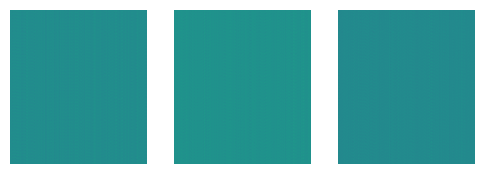

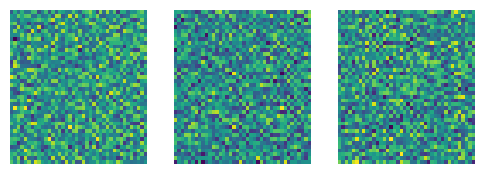

In [23]:
Ps = []
for seed in seeds:

    args = Args(**dict(
        tags = ['mnist', 'hparams'],
        seed = seed,
        data_kwargs = {'grid_size': [7, 7], 'noise_std': 0.0},
        transform_kwargs = {'eps_mult': [0, 0, 1, 1], 'only_flip': False},
        data_dir = '../data/MNIST',
    ))

    run_id = find_id_for_P(args)
    P = load_P_pred(run_id)
    Ps.append(P)
Ps = torch.stack(Ps)

plot2d(Ps, l=2)
plot2d(Ps[:, :40, :40], l=2)

## MNIST predict eps_mult = 0. 0. 1. 1.

In [ ]:
plot_data(datasets['mnist'], N_plot=5)